In [29]:
import os, copy
import pandas as pd
import datetime as dt
import numpy as np

import sqlalchemy as db
from sqlalchemy import create_engine, MetaData, Table, select

from sklearn import model_selection
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.utils import resample

import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Dropout

import seaborn as sns
import matplotlib.pyplot as plt
from autoviz.AutoViz_Class import AutoViz_Class

import warnings
warnings.filterwarnings('ignore')



# Load Data

In [193]:
def export_db_to_df(db_path):
    '''To export data from db to dataframe'''
    # Check if the database files exist
    if not os.path.exists(db_path):
        print("Database files not found. Please make sure they are in the 'data' folder.")
        exit(1)

    # Create SQLAlchemy engine for database
    engine = db.create_engine(f"sqlite:///{db_path}")
    connection = engine.connect()

    # Create SQLAlchemy MetaData objects
    metadata = db.MetaData()
    metadata.reflect(bind=engine)

    # Print table names
    table_name = list(metadata.tables.keys())[0]
    print("Tables in database:")
    print(table_name)


    # Query entire table and export into df
    db_table = Table(table_name, metadata, autoload=True, autoload_with=engine)
    query = db.select(db_table)
    result = connection.execute(query)
    df = pd.DataFrame(result.fetchall(), columns=db_table.columns.keys())
    df = df.reset_index(drop=True)
    print("Complete export to dataframe")

    return df


In [208]:
# Paths to the database files
dir = r"C:\Users\Administrator\Documents\gitHub\NTU\InterpolationModel\data"
pre_purchase_db_path = os.path.join(dir, "cruise_pre.db")
post_trip_db_path = os.path.join(dir, "cruise_post.db")

pre_cruise = export_db_to_df(pre_purchase_db_path)
post_cruise = export_db_to_df(post_trip_db_path)

Tables in database:
cruise_pre
Complete export to dataframe
Tables in database:
cruise_post
Complete export to dataframe


# Feature Engineer

In [209]:
categorical_column = [
                    "Gender", 
                    "Source of Traffic",
                    "Cruise Name"
                     ]
to_be_scaled = [
                "Onboard Wifi Service",
                "Onboard Dining Service", 
                "Onboard Entertainment"
                ]

numerical_column = [
                    "Embarkation/Disembarkation time convenient", 
                    "Ease of Online booking", 
                    "Gate location", 
                    "Online Check-in",
                    "Cabin Comfort",
                    "Cabin service",
                    "Baggage handling",
                    "Port Check-in Service",
                    "Onboard Service",
                    "Cleanliness",
                    "Dining",
                    "Cruise Distance",
                    "Onboard Wifi Service",
                    "Onboard Dining Service", 
                    "Onboard Entertainment",
                    "WiFi",
                    "Entertainment",
                    "Age",
                    "Month of purchase",
                    "Day of purchase",
                    "Hours of purchase"
                    ]

In [210]:
# merge data
combined_data = pre_cruise.merge(post_cruise, on='Ext_Intcode', how='inner')

# drop irrelevant data
combined_data = combined_data.drop(["Ext_Intcode", "index_x", "index_y"], axis = 1)


In [211]:
# use Age instead of Date of Birth
combined_data["Date of Birth"] = pd.to_datetime(combined_data["Date of Birth"], format="mixed")
current_date = dt.datetime.now()
combined_data["Age"] = current_date.year - combined_data["Date of Birth"].dt.year

combined_data["Age"] = combined_data["Age"].fillna(0)
combined_data = combined_data.drop(["Date of Birth"], axis = 1)

In [212]:
# combined_data["Age"][(combined_data["Age"] < 18) & (combined_data["Age"] != 0)].count()
combined_data["Age"][combined_data["Age"] >150].count()

3694

In [213]:
# clean up for Cruise Name
rectify_for_cruise_name = {'lAPRAS':'Lapras', 'IAPRAS':'Lapras', 'lap':'Lapras', 'lapras':'Lapras', 'blast':'Blastoise', 'blast0ise':'Blastoise', 'blastoise':'Blastoise'}

for wrong_name, correct_name in rectify_for_cruise_name.items():
    combined_data["Cruise Name"] = combined_data["Cruise Name"].replace(wrong_name, correct_name)


In [214]:
# clean up text data that needs to be convert to scale
scale = {'Not at all important':1, 'A little important':2, 'Somewhat important':3, 'Very important':4, 'Extremely important':5}

for text, ratings in scale.items():
    combined_data[to_be_scaled] = combined_data[to_be_scaled].replace(text, int(ratings))


In [215]:
# clean up Cruise Distance by converting all to miles measurement
distance = combined_data["Cruise Distance"]

# keep all missing data in Cruise Distance as 0
missing_distance = distance[distance.isna()]
distance = distance.fillna("")

# look for KM, obtain the value and convert it to miles
word_pattern = r'\bKM\b'
word_found = distance.str.contains(word_pattern, regex=True)
distance_in_km = distance[word_found]
distance_in_km = distance_in_km.str.replace(" KM", "")
distance_in_km = distance_in_km.astype(int)
distance_km_convert_to_miles = distance_in_km * 0.621371

# look for miles and obtain the value
word_pattern = r'\bMiles\b'
word_found = distance.str.contains(word_pattern, regex=True)
distance_in_miles = distance[word_found]
distance_in_miles = distance_in_miles.str.replace(" Miles", "")
distance_in_miles = distance_in_miles.astype(int)

# get new Cruise Distance
distance_final = pd.concat([missing_distance, distance_km_convert_to_miles, distance_in_miles], axis = 0)
distance_final = distance_final.sort_index()
distance_final = distance_final.fillna(0)
distance_final = distance_final.astype(int)
combined_data["Cruise Distance"] = distance_final



In [216]:
# get information from the logging, see if ticket type has any relation to time of the day, day of the month as well as month of the year 
logs = combined_data["Logging"]
logs = pd.to_datetime(logs, format="mixed")
combined_data["Month of purchase"] = logs.dt.month
combined_data["Day of purchase"] = logs.dt.day
combined_data["Hours of purchase"] = logs.dt.hour
combined_data = combined_data.drop(['Logging'], axis = 1)

In [217]:
# fill in missing data as 0 in the numerical columns and "Missing" in the categorical columns
combined_data[numerical_column] = combined_data[numerical_column].fillna(0)
combined_data[categorical_column] = combined_data[categorical_column].fillna("Missing")

# drop rows that does not have ticket type data
combined_data = combined_data.dropna(subset=["Ticket Type"])
combined_data = combined_data.reset_index(drop = True)


# EDA

### 1.initial assessment

In [67]:
to_be_plot = [
                    "Embarkation/Disembarkation time convenient", 
                    "Ease of Online booking", 
                    "Gate location", 
                    "Online Check-in",
                    "Cabin Comfort",
                    "Cabin service",
                    "Baggage handling",
                    "Port Check-in Service",
                    "Onboard Service",
                    "Cleanliness",
                    "Dining",
                    "Onboard Wifi Service",
                    "Onboard Dining Service", 
                    "Onboard Entertainment",
                    "WiFi",
                    "Entertainment"
                    ]

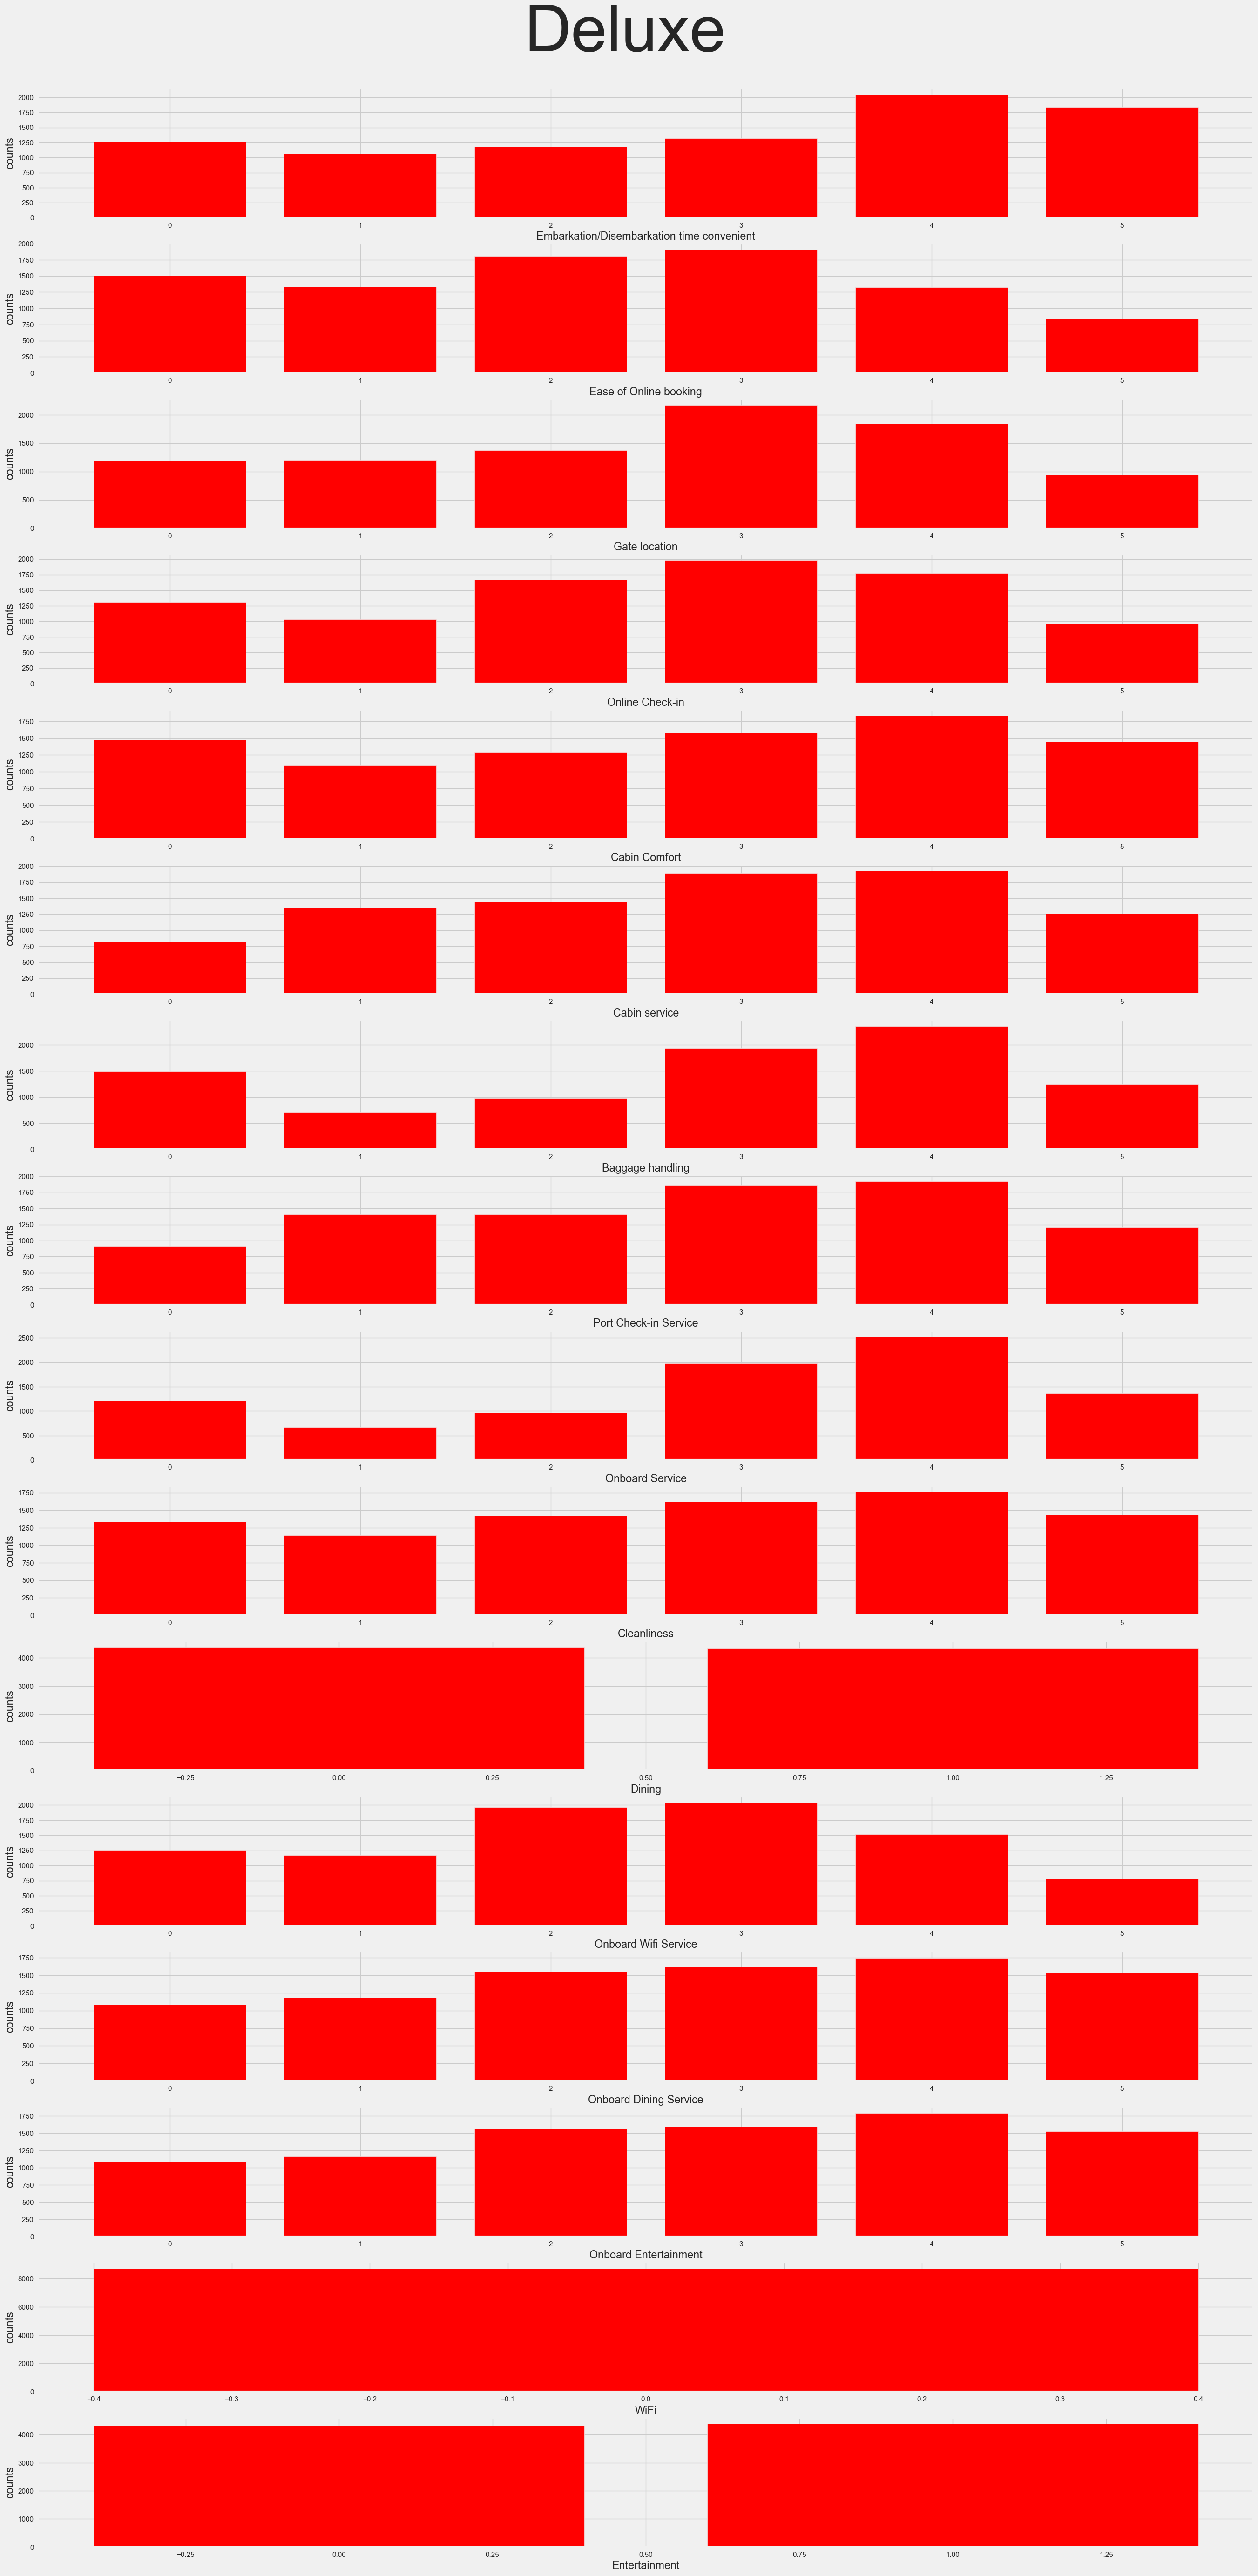

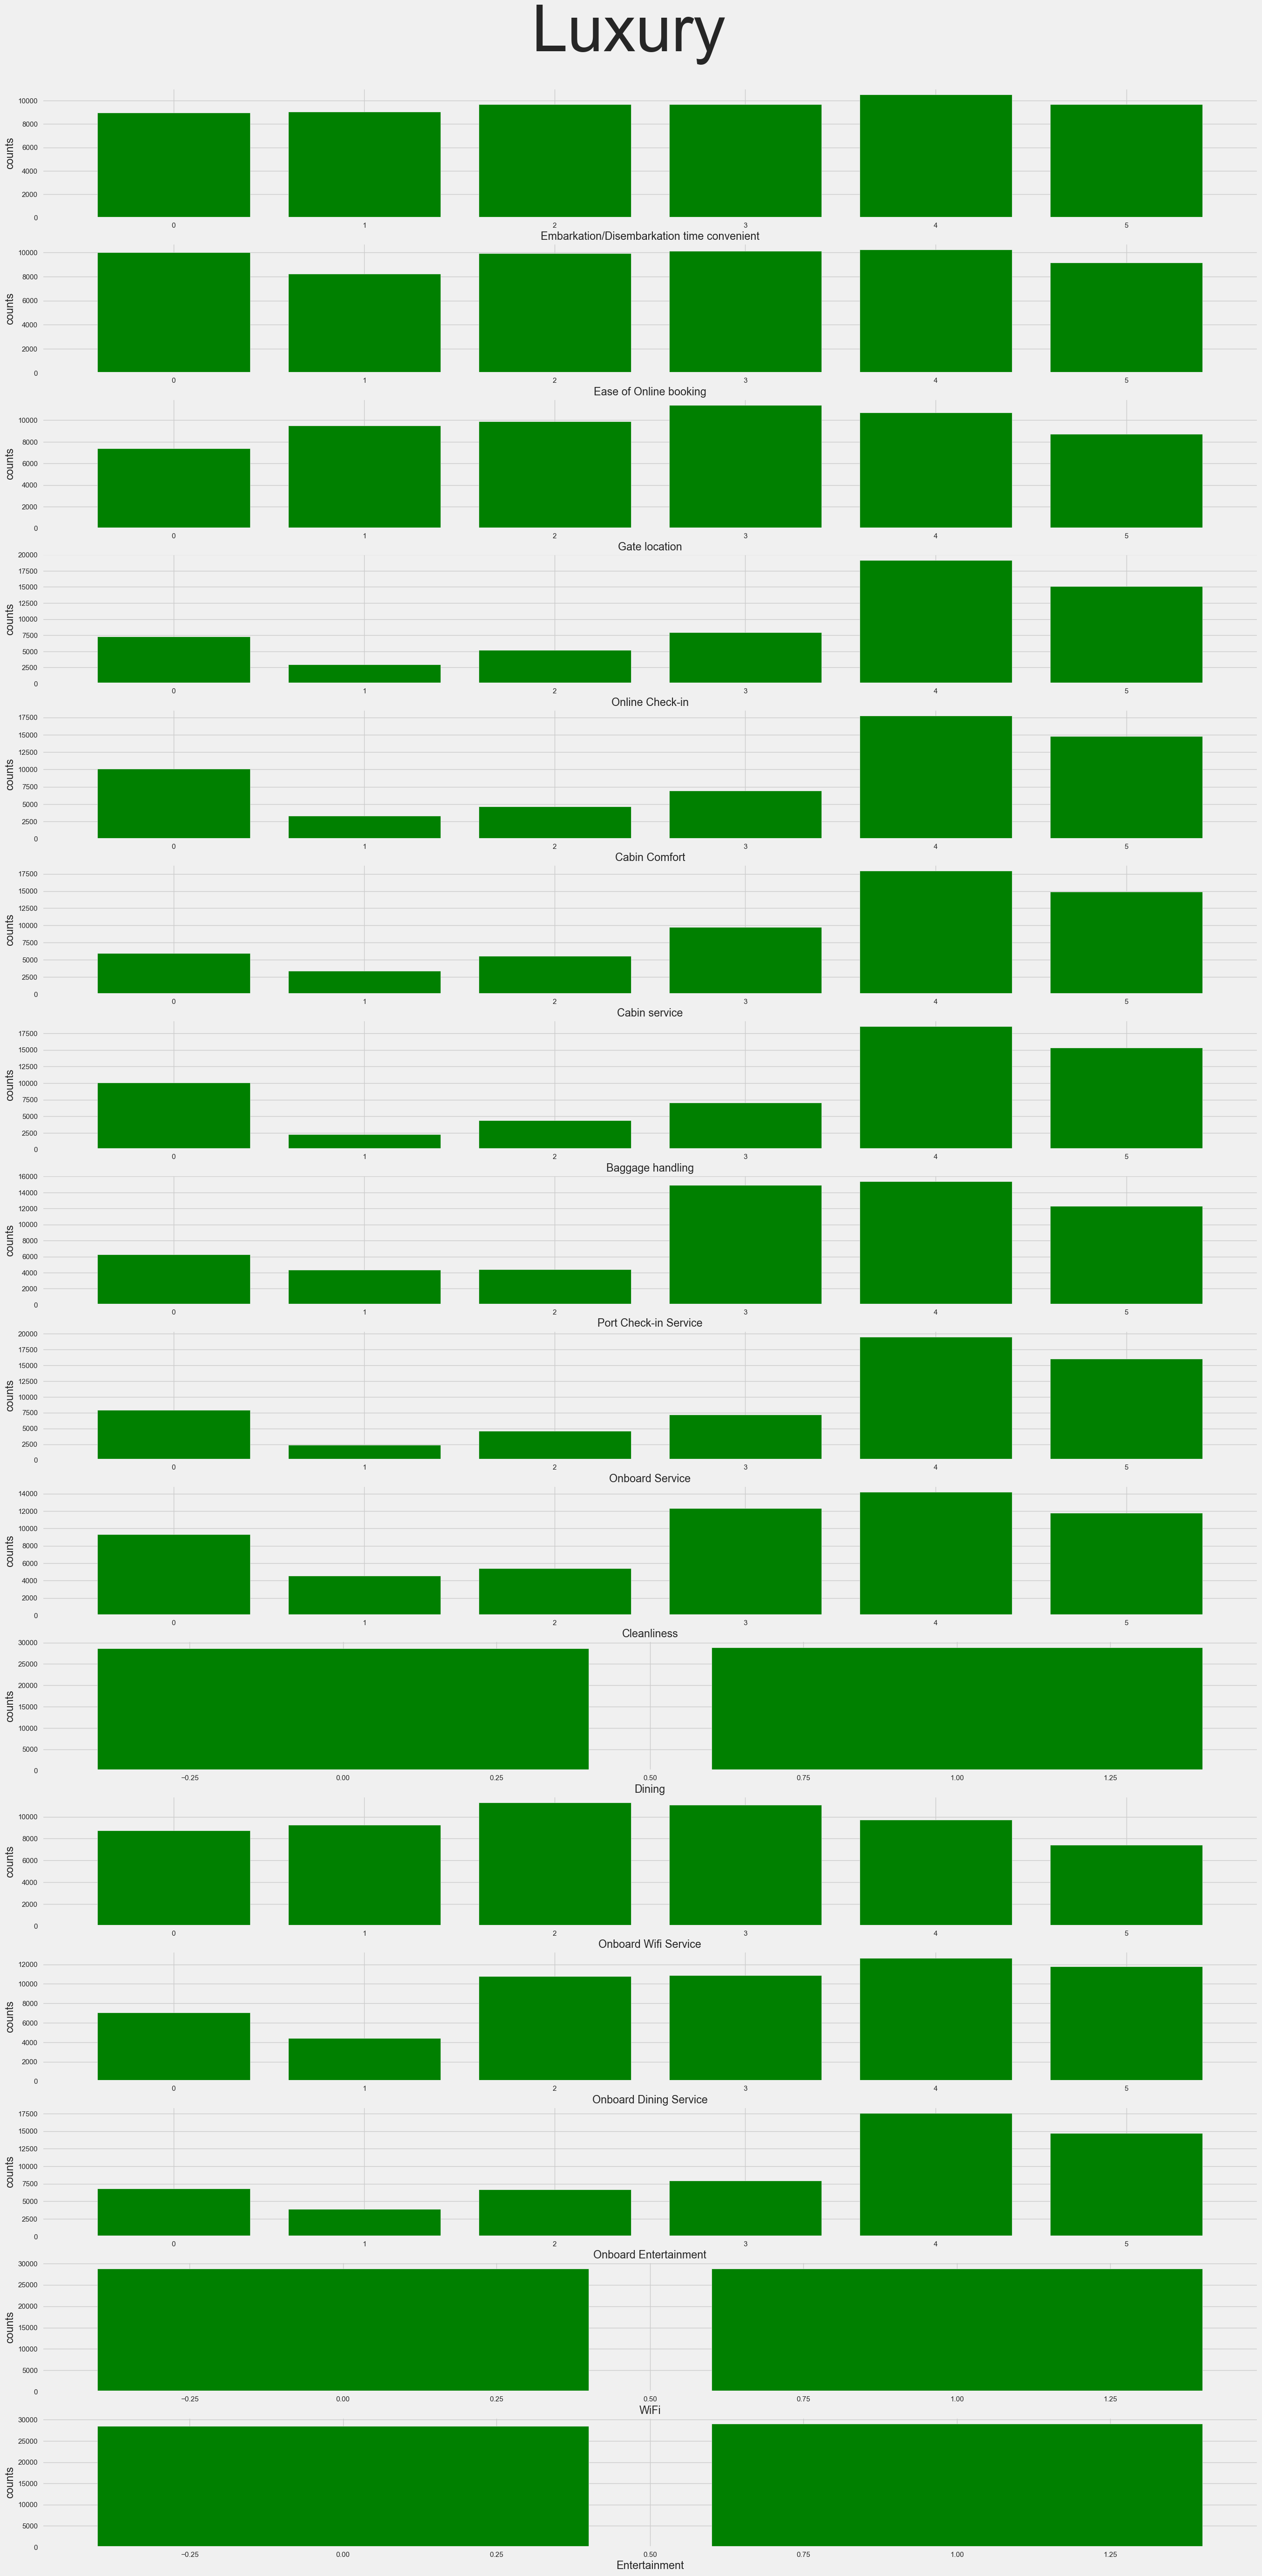

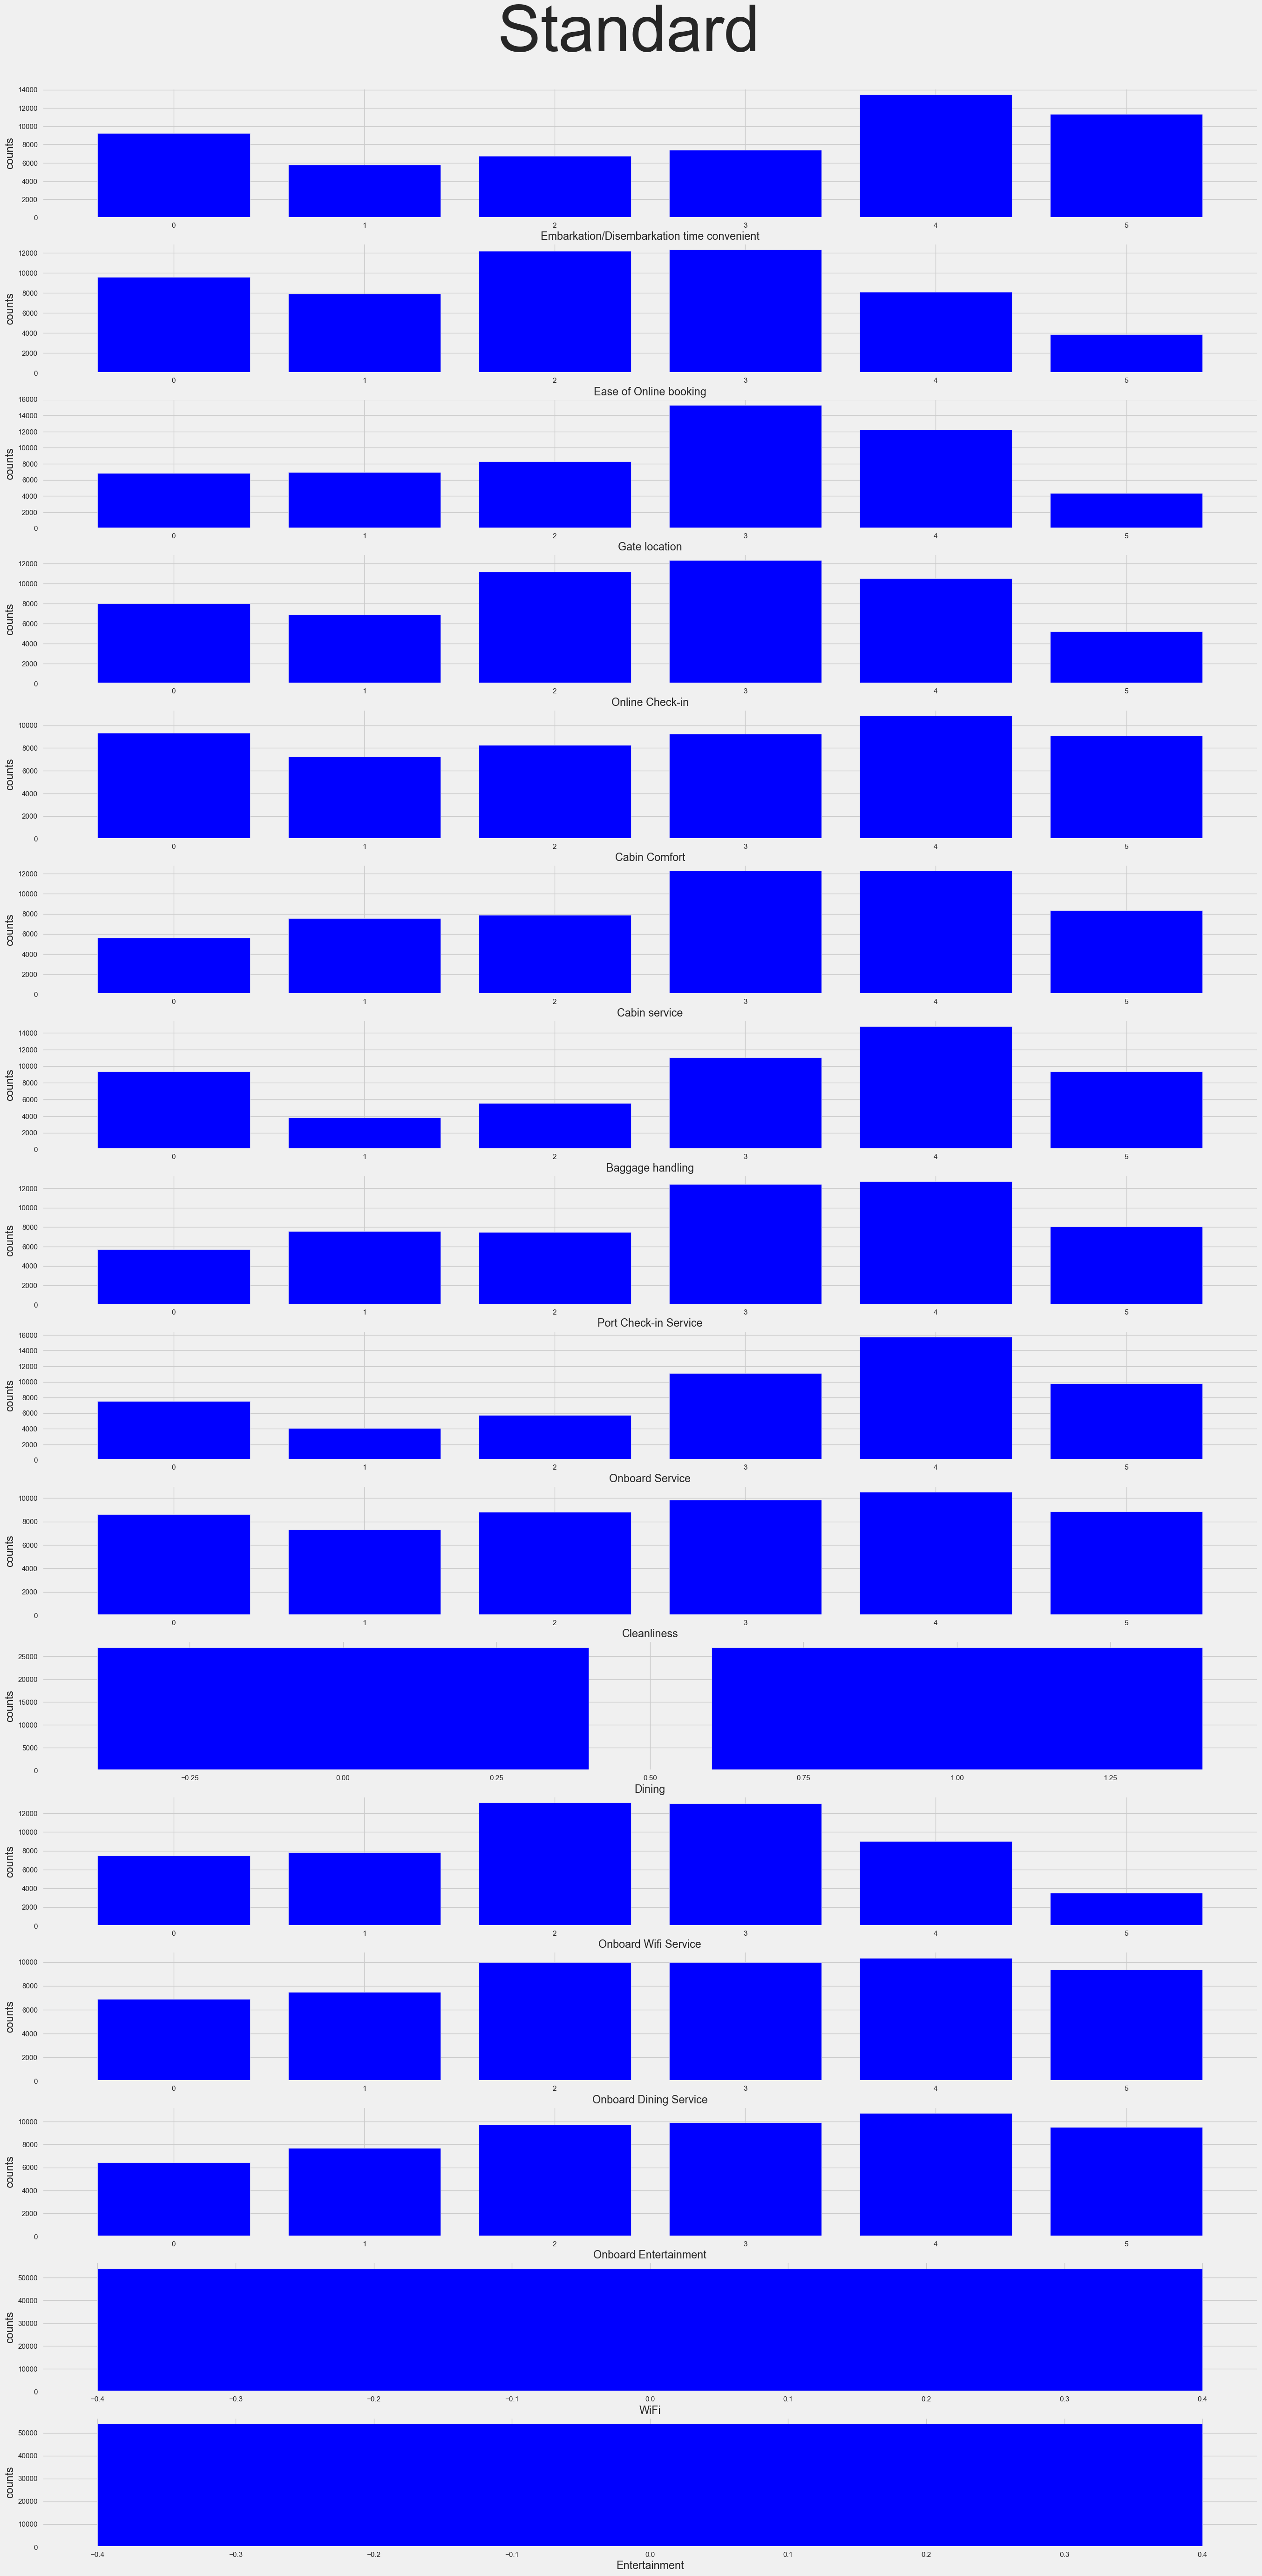

In [68]:
%matplotlib inline

# plot by grouping up Ticket Type to look at the ratings data
grouped = combined_data.groupby("Ticket Type")

bar_color =  ["red", 'green', 'blue']

for i, (name, group) in enumerate(grouped):
    fig, axes = plt.subplots(nrows=len(to_be_plot), ncols = 1, figsize=(30, 60))
    for j, feature in enumerate(to_be_plot):
        category = list(group[feature].value_counts().keys())
        counts = group[feature].value_counts().values
        axes[j].bar(category, counts, color = bar_color[i])
        axes[j].set_xlabel(str(feature))
        axes[j].set_ylabel("counts")
    fig.suptitle(name, fontsize = 100)
    plt.subplots_adjust(top=0.95)


Shape of your Data Set loaded: (120282, 25)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
    25 Predictors classified...
        No variables removed since no ID or low-information variables found in data set
To fix data quality issues automatically, import FixDQ from autoviz...
    Alert: Dropping 5576 duplicate rows can sometimes cause column data types to change to object. Double-check!


Number of All Scatter Plots = 105


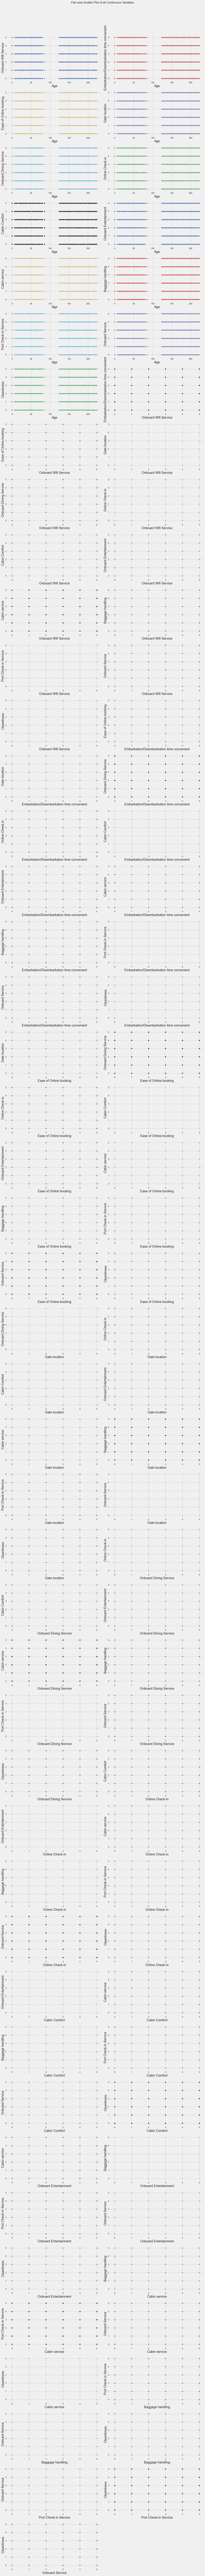

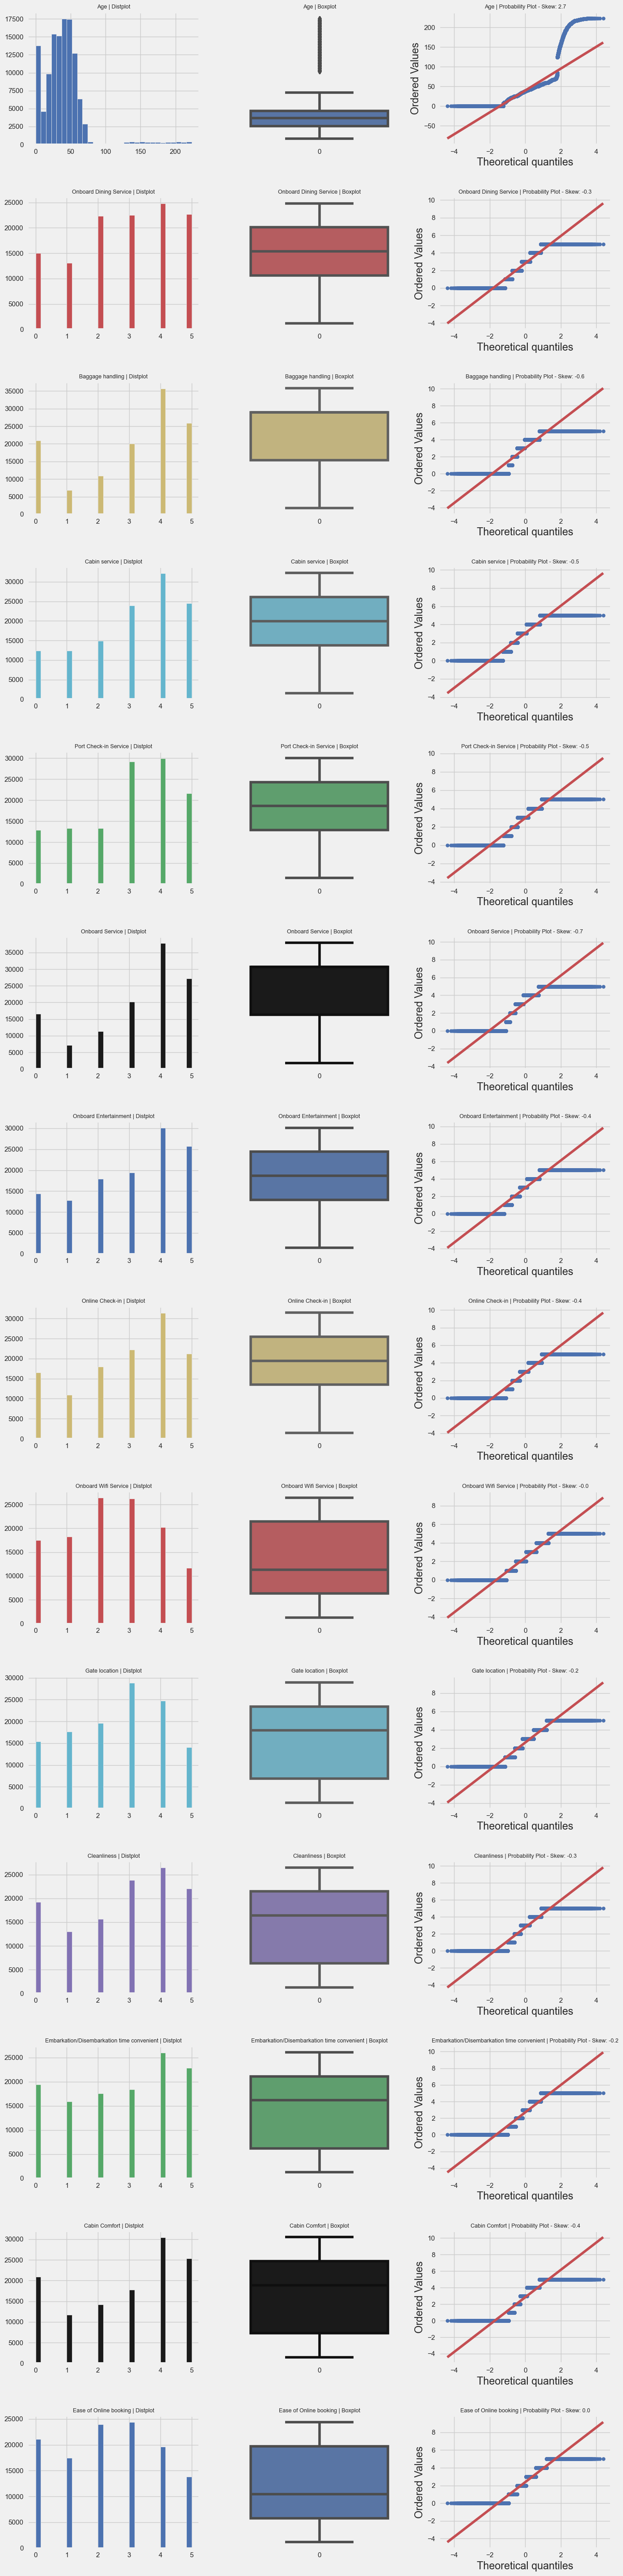

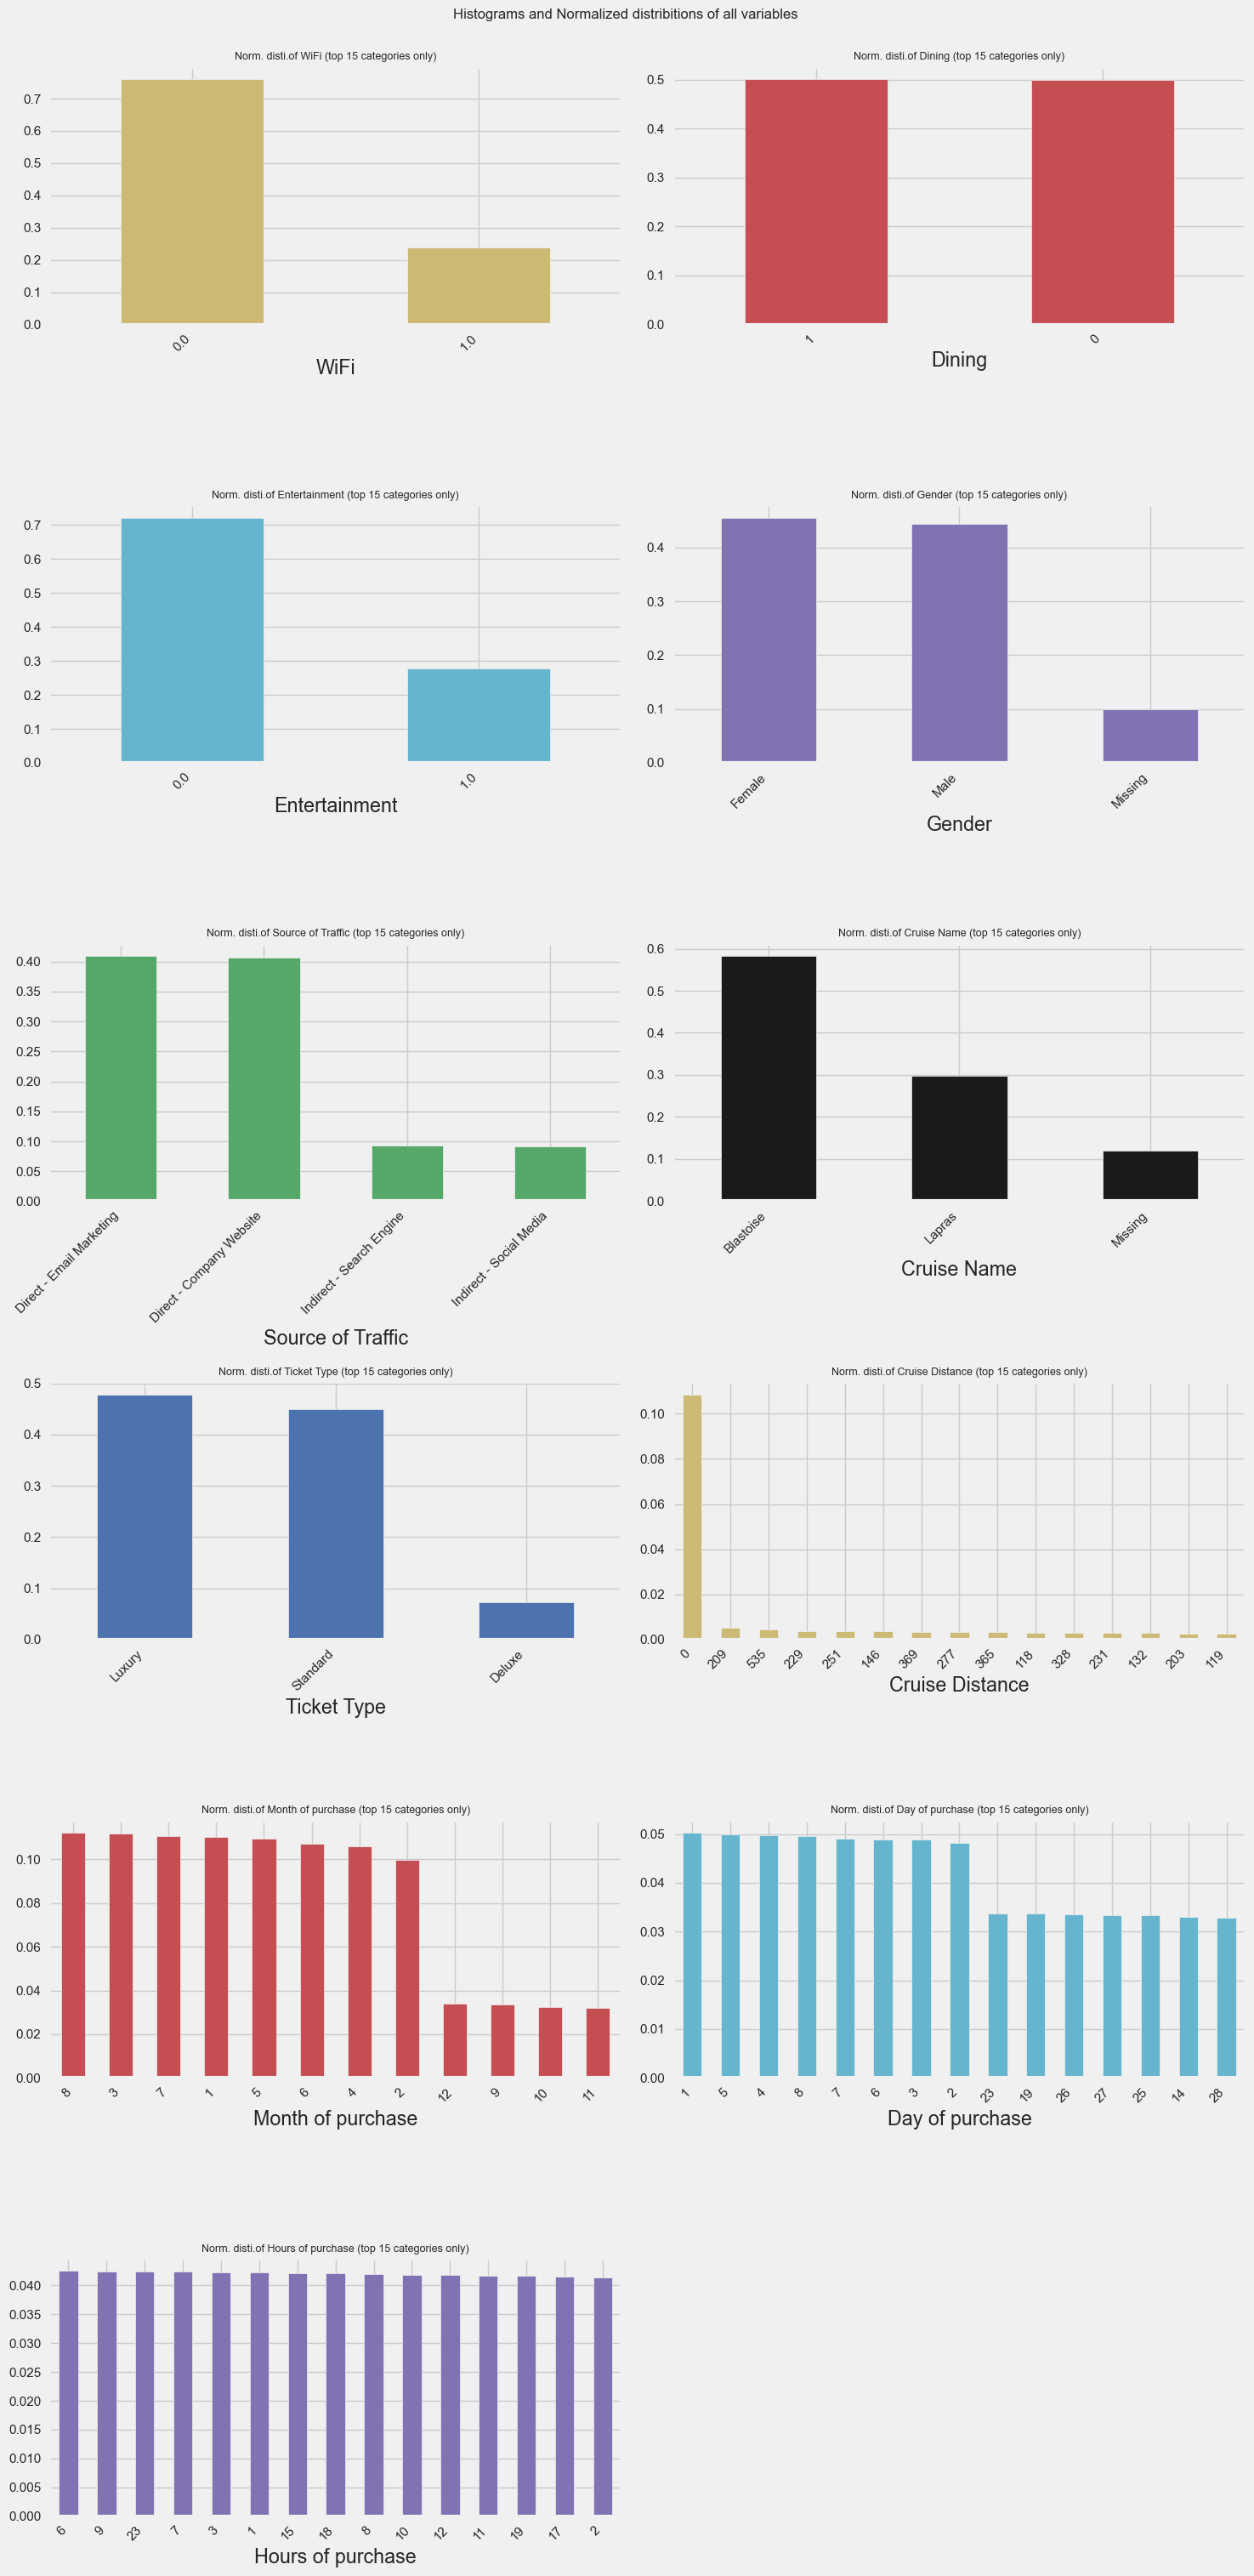

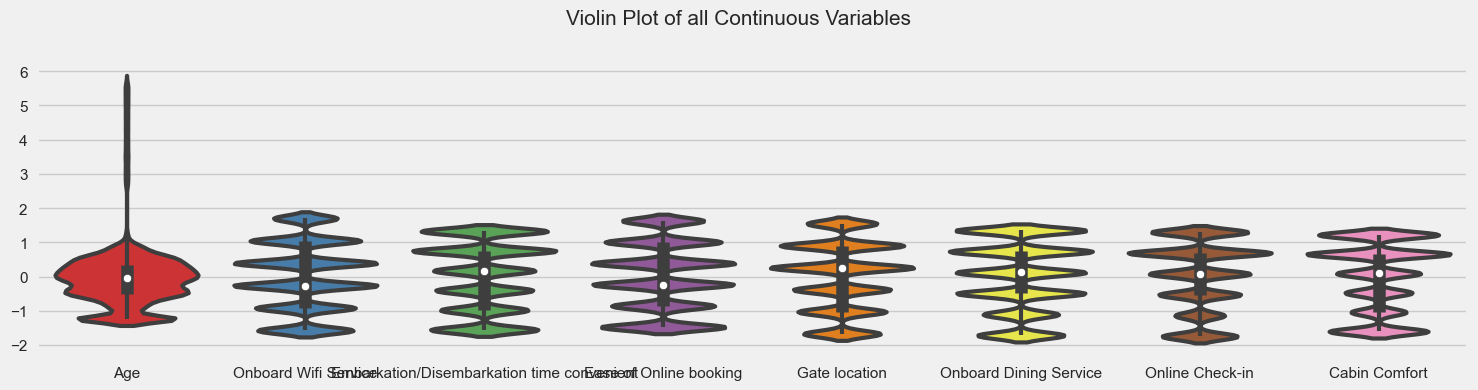

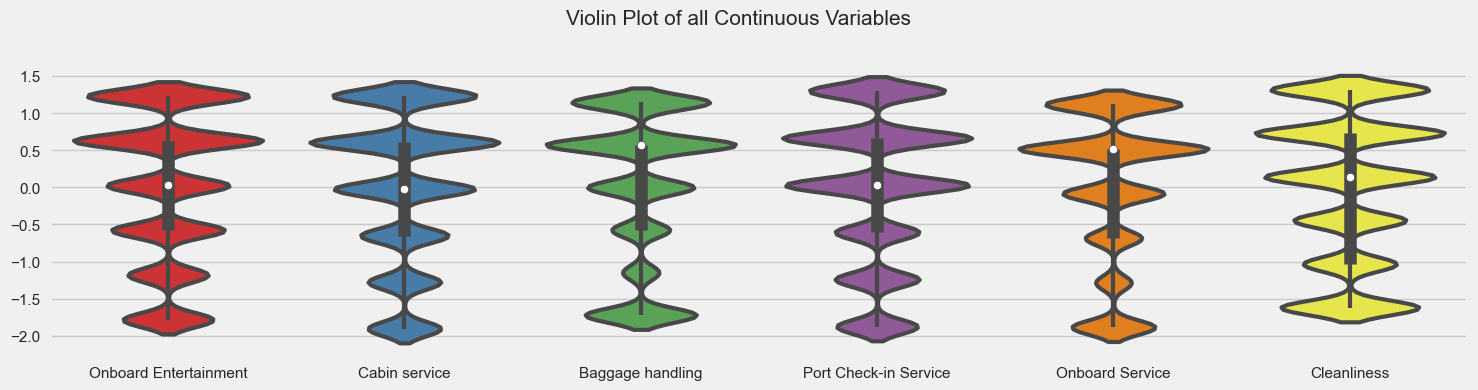

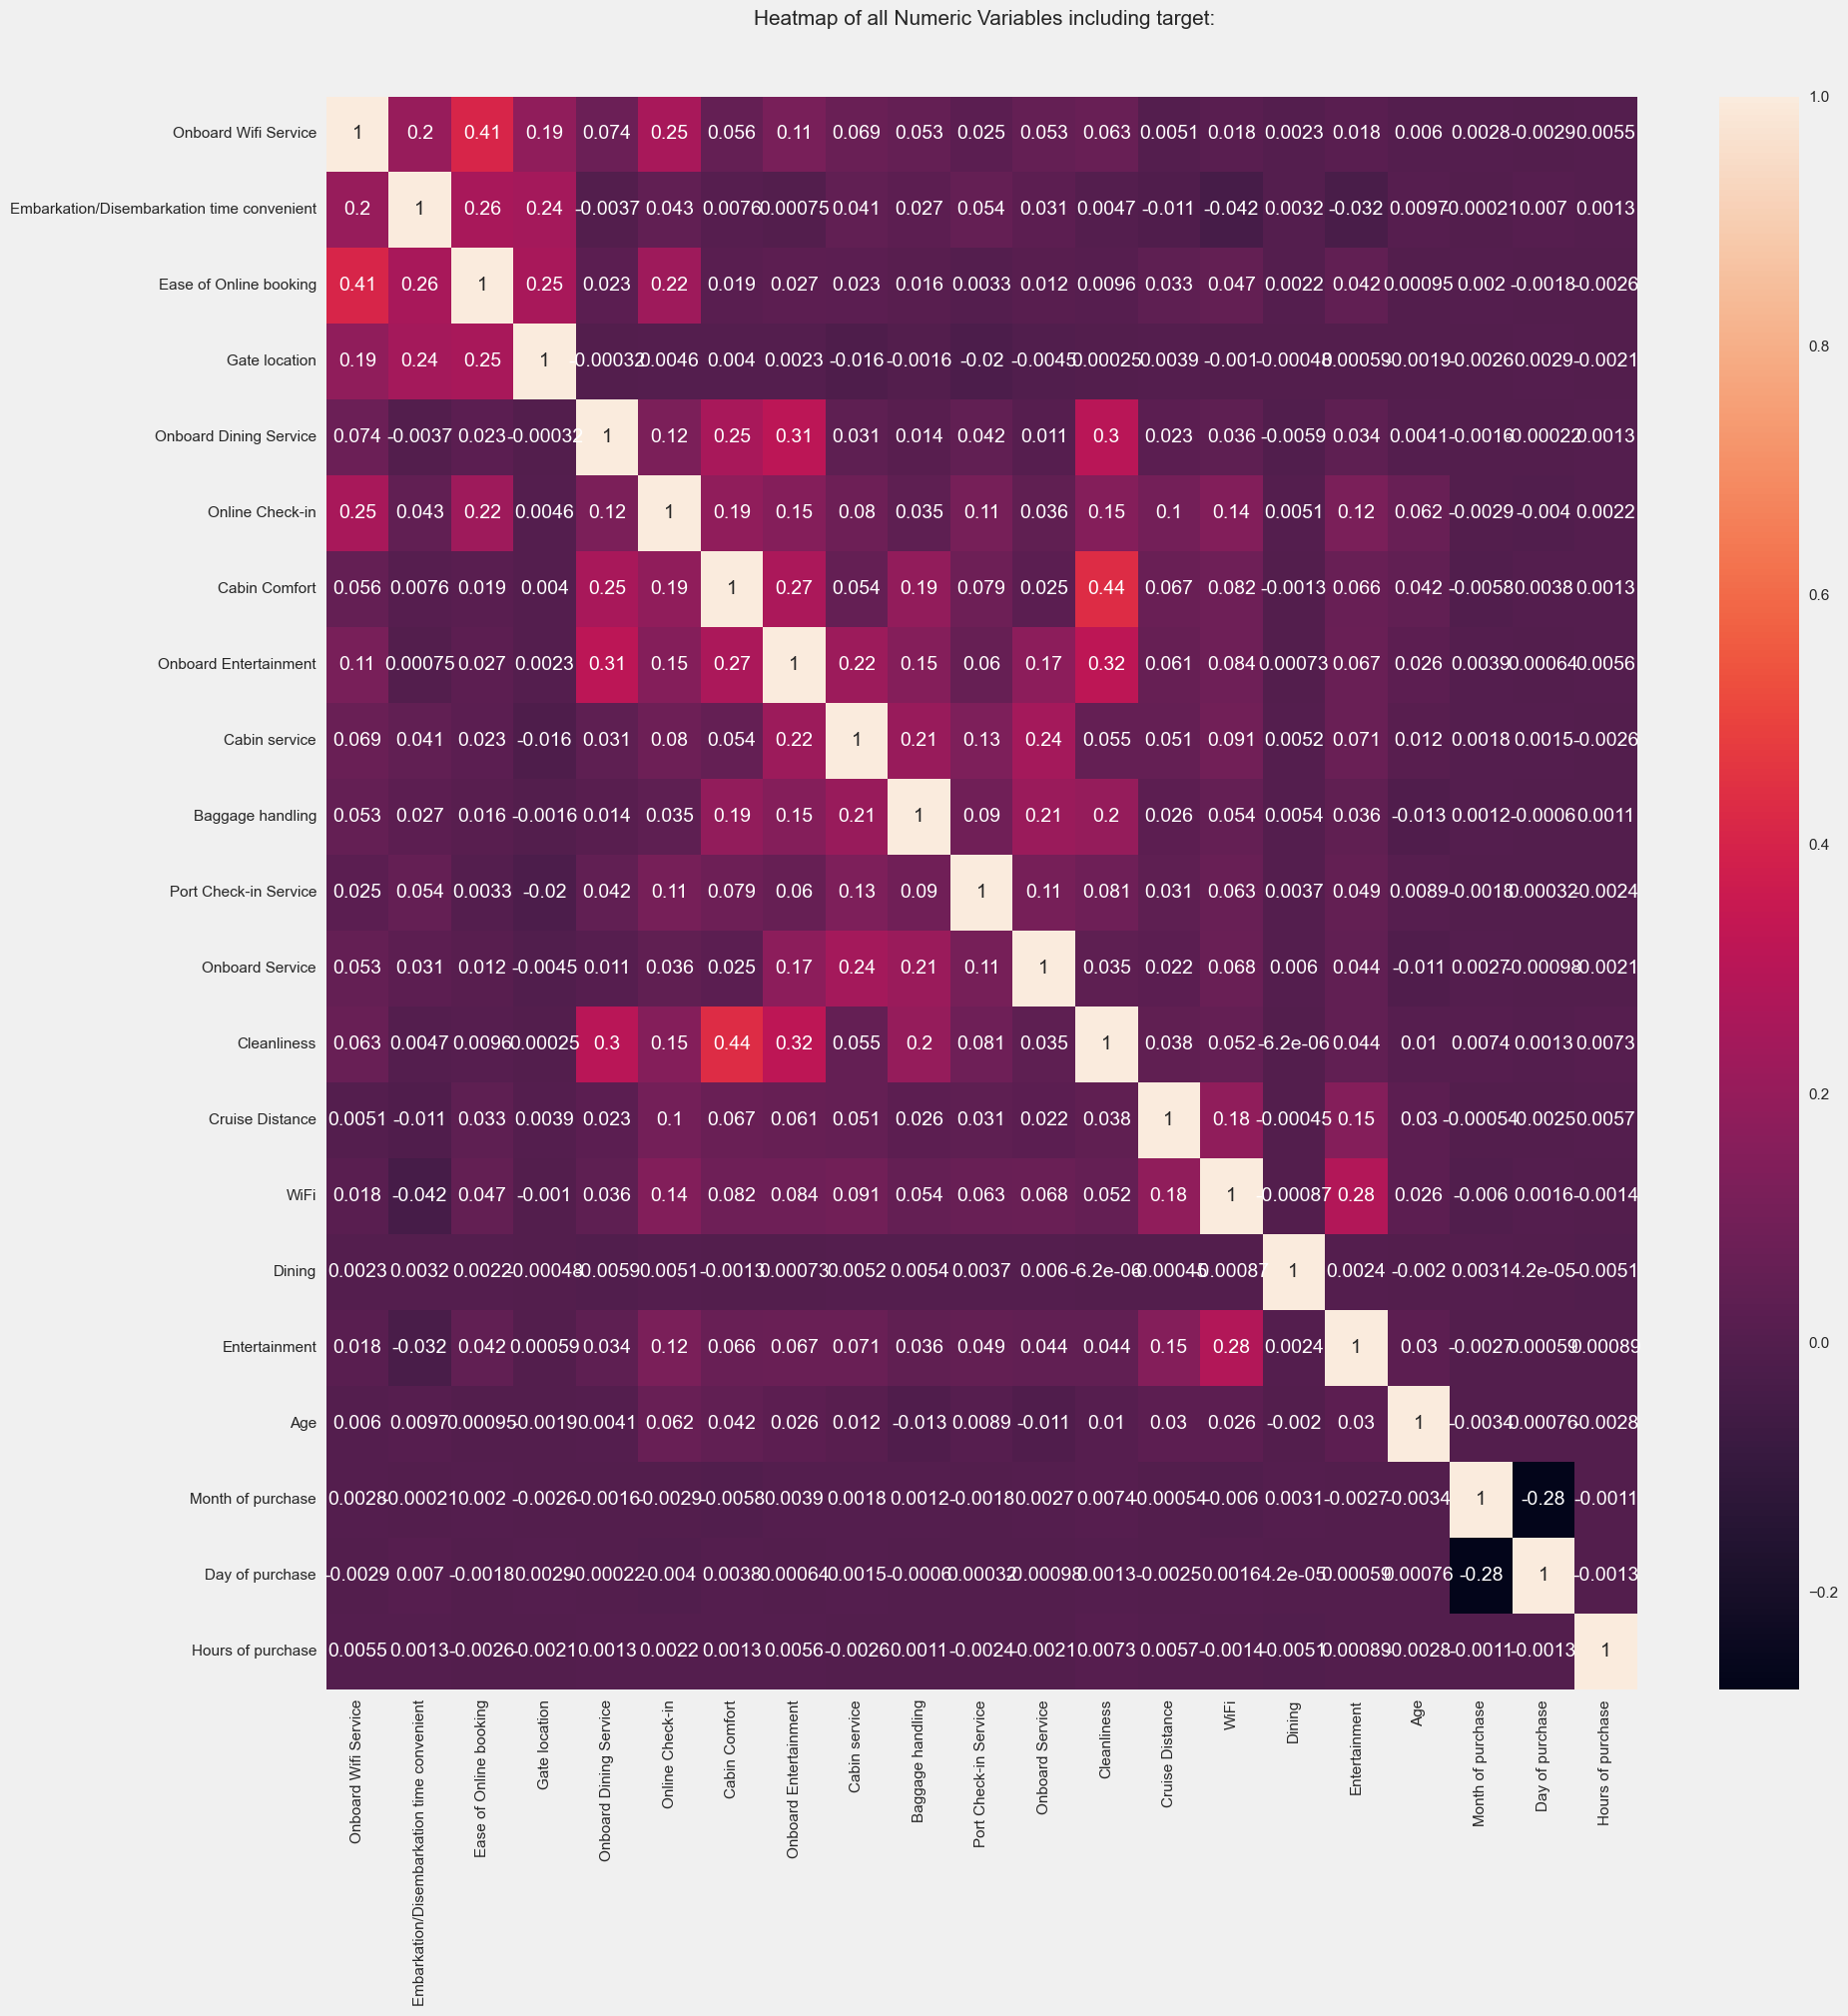

All Plots done
Time to run AutoViz = 93 seconds 

 ###################### AUTO VISUALIZATION Completed ########################


Gender     Source of Traffic      Onboard Wifi Service  \
0       Female   Indirect - Social Media           1.0           
1       Female  Indirect - Search Engine           0.0           
2       Female  Direct - Company Website           4.0           
3         Male  Direct - Company Website           3.0           
4         Male  Direct - Company Website           3.0           
...        ...                       ...                   ...   
120277  Female  Indirect - Search Engine           2.0           
120278  Female  Indirect - Search Engine           2.0           
120279  Female  Indirect - Search Engine           2.0           
120280    Male  Direct - Email Marketing           5.0           
120281    Male  Direct - Company Website           0.0           

        Embarkation/Disembarkation time convenient  Ease of Online booking  \
0                           4.0                               1.0            
1                           3.0                               0.0            
2                           4.0                               4.0            
3                           4.0                               2.0            
4                           4.0                               2.0            
...                                            ...                     ...   
120277                      1.0                               1.0            
120278                      1.0                               1.0            
120279                      1.0                               1.0            
120280                      5.0                               5.0            
120281                      0.0                               0.0            

        Gate location  Onboard Dining Service  Online Check-in  Cabin Comfort  \
0            0.0                 4.0                 0.0             4.0        
1            5.0                 0.0                 0.0             5.0        
2            4.0                 3.0                 4.0             4.0        
3            0.0                 1.0                 2.0             0.0        
4            0.0                 1.0                 2.0             0.0        
...               ...                     ...              ...            ...   
120277       4.0                 0.0                 2.0             0.0        
120278       4.0                 0.0                 2.0             4.0        
120279       4.0                 0.0                 2.0             4.0        
120280       5.0                 5.0                 5.0             5.0        
120281       1.0                 0.0                 0.0             2.0        

        Onboard Entertainment  Cabin service  Baggage handling  \
0                0.0                2.0              3.0         
1                5.0                2.0              1.0         
2                0.0                0.0              0.0         
3                1.0                3.0              0.0         
4                1.0                3.0              0.0         
...                       ...            ...               ...   
120277           4.0                5.0              0.0         
120278           4.0                5.0              4.0         
120279           4.0                5.0              4.0         
120280           5.0                4.0              5.0         
120281           5.0                2.0              1.0         

        Port Check-in Service  Onboard Service  Cleanliness Cruise Name  \
0                4.0                 4.0            4.0       Blastoise   
1                2.0                 3.0            0.0          Lapras   
2                3.0                 2.0            4.0          Lapras   
3                5.0                 2.0            0.0          Lapras   
4                5.0                 2.0            0.0          Lapras   
...                       ...              ...          ...   

In [69]:
%matplotlib inline
AV = AutoViz_Class()
AV.AutoViz("", dfte = combined_data)

### 2.Findings

In [ ]:
# to remove Wifi and Entertainment as 

# Pre-processing

In [218]:
def preprocess(df, sampling = True, ohe_target_variable = True):
    data = copy.copy(df)
    
    if sampling == True:
        # balanced subsampling: oversample minority and under sample majority
        majority_class1 = data[data['Ticket Type'] == "Luxury"]
        majority_class2 = data[data['Ticket Type'] == "Standard"]
        minority_class = data[data['Ticket Type'] == "Deluxe" ]

        # Determine the size of the minority class after resampling
        target_count = minority_class.shape[0]
        majority_class1 = resample(majority_class1, replace=False, n_samples=target_count, random_state=2023)
        majority_class2 = resample(majority_class2, replace=False, n_samples=target_count, random_state=2023)

        final_data = pd.concat([majority_class1, majority_class2, minority_class])
        # Shuffle the dataset to mix the classes
        final_data = final_data.sample(frac=1, random_state=2023).reset_index(drop=True)

    else:
        final_data = data

    if ohe_target_variable == True:
        y = pd.get_dummies(final_data["Ticket Type"], drop_first = False).replace(True, int(1)).replace(False, int(0))
    else:
        y = final_data["Ticket Type"]
    
    final_data = final_data.drop(["Ticket Type"], axis = 1)
    return final_data, y

In [219]:
def transform_data(data, cat = categorical_column, num = numerical_column, ohe = True, norm = True):
    if ohe == True:
        enc = OneHotEncoder(handle_unknown = 'ignore')
        enc.fit(data[cat])
        feature_name_categorical = enc.get_feature_names(data[cat].columns)
        data_cat = enc.fit_transform(data[cat]).toarray()
        data_cat_df= pd.DataFrame(data_cat, columns= feature_name_categorical)
    else:
        data_cat_df= pd.DataFrame(data[cat], columns= cat)
        data_cat_df = data_cat_df.reset_index(drop=True)


    if norm == True:
        scaler = MinMaxScaler()
        scaler.fit(data[num])
        feature_name_numerical = data[num].columns
        data_num = scaler.transform(data[num])
        data_num_df = pd.DataFrame(data_num, columns = feature_name_numerical)
    else:
        data_num_df = pd.DataFrame(data[num], columns = num)
        data_num_df = data_num_df.reset_index(drop=True)



    final_data = pd.concat([data_cat_df, data_num_df], axis = 1)
    final_data = final_data.reset_index(drop = True)
    return final_data


# Neural Network

In [229]:
# resampled_data, resampled_y_ohe = resampling(combined_data, sampling = True)
final_data, y = preprocess(combined_data, sampling = False, ohe_target_variable = True)
x_train, x_test, y_train, y_test = model_selection.train_test_split(final_data, y, test_size = 0.2, stratify=y, random_state = 2023)


In [230]:
nn_x_train = transform_data(x_train, ohe = True, norm = True)
nn_x_test = transform_data(x_test, ohe = True, norm = True)

In [231]:
model = Sequential()
model.add(Dense(78, input_dim=nn_x_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(39, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(19, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(nn_x_train, y_train, epochs=10, batch_size=64, verbose=1)

Epoch 1/10
1504/1504 [==============================] - 4s 2ms/step - loss: 0.5281 - accuracy: 0.8027
Epoch 2/10
1504/1504 [==============================] - 4s 2ms/step - loss: 0.4429 - accuracy: 0.8345
Epoch 3/10
1504/1504 [==============================] - 4s 2ms/step - loss: 0.4222 - accuracy: 0.8425
Epoch 4/10
1504/1504 [==============================] - 4s 2ms/step - loss: 0.4101 - accuracy: 0.8463
Epoch 5/10
1504/1504 [==============================] - 4s 2ms/step - loss: 0.4010 - accuracy: 0.8507
Epoch 6/10
1504/1504 [==============================] - 4s 2ms/step - loss: 0.3942 - accuracy: 0.8546
Epoch 7/10
1504/1504 [==============================] - 4s 2ms/step - loss: 0.3905 - accuracy: 0.8568
Epoch 8/10
1504/1504 [==============================] - 3s 2ms/step - loss: 0.3842 - accuracy: 0.8588
Epoch 9/10
1504/1504 [==============================] - 3s 2ms/step - loss: 0.3811 - accuracy: 0.8600
Epoch 10/10
1504/1504 [==============================] - 4s 2ms/step - loss: 0.377

In [232]:
# no sampling
nn_y_pred = model.predict(nn_x_test)
test_loss, test_acc= model.evaluate(nn_x_test, y_test)
print(classification_report(y_test, nn_y_pred>0.5))

752/752 [==============================] - 1s 1ms/step - loss: 0.3645 - accuracy: 0.8680
              precision    recall  f1-score   support

           0       0.71      0.18      0.29      1743
           1       0.93      0.86      0.89     11514
           2       0.83      0.98      0.90     10800

   micro avg       0.87      0.86      0.87     24057
   macro avg       0.82      0.67      0.69     24057
weighted avg       0.87      0.86      0.85     24057
 samples avg       0.86      0.86      0.86     24057



In [97]:
# balance subsampling
y_pred = model.predict(nn_x_test)
test_loss, test_acc= model.evaluate(nn_x_test, y_test)
print(classification_report(y_test, y_pred>0.5))

164/164 [==============================] - 1s 2ms/step - loss: 0.5894 - accuracy: 0.7184
              precision    recall  f1-score   support

           0       0.75      0.51      0.61      1742
           1       0.99      0.64      0.78      1743
           2       0.63      0.94      0.76      1743

   micro avg       0.74      0.70      0.72      5228
   macro avg       0.79      0.70      0.71      5228
weighted avg       0.79      0.70      0.71      5228
 samples avg       0.70      0.70      0.70      5228



# Random Forest

In [173]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score

In [224]:
# resampled_data, resampled_y_ohe = resampling(combined_data, sampling = True)
final_data, y = preprocess(combined_data, sampling = False, ohe_target_variable = False)
x_train, x_test, y_train, y_test = model_selection.train_test_split(final_data, y, test_size = 0.2, stratify=y, random_state = 2023)


In [225]:
rf_x_train = transform_data(x_train, ohe = True, norm = False)
rf_x_test = transform_data(x_test, ohe = True, norm = False)


In [226]:
# Instantiate and fit the RandomForestClassifier
forest = RandomForestClassifier(random_state= 2023)
forest.fit(rf_x_train, y_train)

# Make predictions for the test set
y_pred_test_forest = forest.predict(rf_x_test)

# # View accuracy score
print(accuracy_score(y_test, y_pred_test_forest))

# # View confusion matrix for test_forest data and predictions
print(confusion_matrix(y_test, y_pred_test_forest))

# View the classification report for test_forest data and predictions
print(classification_report(y_test, y_pred_test_forest))

0.897285613334996
[[  565   421   757]
 [  127 10466   921]
 [    0   245 10555]]
              precision    recall  f1-score   support

      Deluxe       0.82      0.32      0.46      1743
      Luxury       0.94      0.91      0.92     11514
    Standard       0.86      0.98      0.92     10800

    accuracy                           0.90     24057
   macro avg       0.87      0.74      0.77     24057
weighted avg       0.90      0.90      0.89     24057



In [660]:
min(y_pred_test_forest.sum(axis = 1))

0